## 3 Answer, Minibatch version for high-level implementation of Softmax Regression

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F

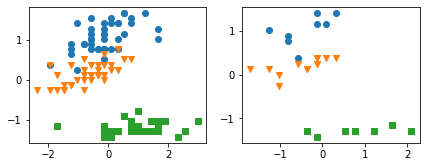

In [ ]:
df = pd.read_csv('./iris.data', index_col=None, header=None)
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']

d = {'Iris-versicolor': 1,
     'Iris-virginica': 2,
     'Iris-setosa': 0,
}

df['y'] = df['y'].map(d)

# Assign features and target

X = torch.tensor(df[['x2', 'x4']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

# Shuffling & train/test split

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent80 = int(shuffle_idx.size(0)*0.8)

X_train, X_test = X[shuffle_idx[:percent80]], X[shuffle_idx[percent80:]]
y_train, y_test = y[shuffle_idx[:percent80]], y[shuffle_idx[percent80:]]

# Normalize (mean zero, unit variance)

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma


fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1])
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], marker='v')
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], marker='s')
ax[1].scatter(X_test[y_test == 2, 0], X_test[y_test == 2, 1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], marker='v')
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], marker='s')
plt.show()

In [ ]:
class SoftmaxRegression2(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression2, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)

        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()

    def forward(self, x):
        logits = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    def predict_labels(self, x):
        logits, probas = self.forward(x)
        labels = torch.argmax(probas, dim=1)
        return labels

    def evaluate(self, x, y):
        labels = self.predict_labels(x).float()
        accuracy = torch.sum(labels.view(-1) == y.float()).item() / y.size(0)
        return accuracy


model2 = SoftmaxRegression2(num_features=2, num_classes=3)
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)

In [ ]:
def comp_accuracy(true_labels, pred_labels):
    accuracy = torch.sum(true_labels.view(-1).float() ==
                         pred_labels.float()).item() / true_labels.size(0)
    return accuracy


num_epochs = 50
epochs_cost = []
for epoch in range(num_epochs):

    current_iteration = 0

    print(f"------Epoch {epoch + 1}-------")

    for iter in range(y_train.shape[0] // 25): # 25 batches for epoch
      mini_x = X_train[current_iteration: current_iteration + 25]
      mini_y = y_train[current_iteration: current_iteration + 25]
      current_iteration += 25

      #### Compute outputs ####
      logits, probas = model2(mini_x)

      #### Compute gradients ####
      cost = F.cross_entropy(logits, mini_y.long())
      optimizer.zero_grad()
      cost.backward()

      #### Update weights ####
      optimizer.step()

      #### Logging ####
      logits, probas = model2(mini_x)
      acc = comp_accuracy(mini_y, torch.argmax(probas, dim=1))
      print('Mini batch: %d' % ((iter + 1 )* 25 ), end="")
      print(' | Train ACC: %.3f' % acc, end="")
      print(' | Cost: %.3f' % F.cross_entropy(logits, mini_y.long()))
      epochs_cost.append(cost)


print('\nModel parameters:')
print('  Weights: %s' % model2.linear.weight)
print('  Bias: %s' % model2.linear.bias)

------Epoch 1-------
Mini batch: 25 | Train ACC: 0.800 | Cost: 1.057
Mini batch: 50 | Train ACC: 0.920 | Cost: 1.002
Mini batch: 75 | Train ACC: 0.880 | Cost: 0.959
Mini batch: 100 | Train ACC: 0.840 | Cost: 0.946
------Epoch 2-------
Mini batch: 25 | Train ACC: 0.800 | Cost: 0.923
Mini batch: 50 | Train ACC: 0.920 | Cost: 0.854
Mini batch: 75 | Train ACC: 0.840 | Cost: 0.827
Mini batch: 100 | Train ACC: 0.840 | Cost: 0.836
------Epoch 3-------
Mini batch: 25 | Train ACC: 0.800 | Cost: 0.823
Mini batch: 50 | Train ACC: 0.920 | Cost: 0.751
Mini batch: 75 | Train ACC: 0.840 | Cost: 0.732
Mini batch: 100 | Train ACC: 0.840 | Cost: 0.757
------Epoch 4-------
Mini batch: 25 | Train ACC: 0.800 | Cost: 0.748
Mini batch: 50 | Train ACC: 0.920 | Cost: 0.676
Mini batch: 75 | Train ACC: 0.840 | Cost: 0.664
Mini batch: 100 | Train ACC: 0.840 | Cost: 0.698
------Epoch 5-------
Mini batch: 25 | Train ACC: 0.800 | Cost: 0.690
Mini batch: 50 | Train ACC: 0.920 | Cost: 0.621
Mini batch: 75 | Train ACC:

In [ ]:
test_acc = model2.evaluate(X_test, y_test)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 83.33%
